# Case 4 - Tritium Spatial Estimation
Welcome to the demonstration notebook where we'll spatially estimate tritium using the **pylenm** package!<br>
Let’s get started!

## Setup
Make sure to install pylenm from https://pypi.org/project/pylenm/ by running `pip install pylenm` in your environment terminal. Once completed, you should be able to import the package. Note: to update to the latest version of pylenm run: `pip install pylenm --upgrade`

In [1]:
# pip install pylenm
# pip install pyproj
# pip install rasterio
# pip install elevation
# pip install richdem       # this only works for python <= 3.10

In [2]:
# Basics
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import  MinMaxScaler
from sklearn.model_selection import LeaveOneOut
from math import sqrt
from sklearn.metrics import r2_score

# # pylenm
# import pylenm
# print("pylenm version: ", pylenm.__version__)
# from pylenm import PylenmDataFactory

# pylenm2
import pylenm2
print("pylenm version: ", pylenm2.__version__)
from pylenm2 import PylenmDataModule

# GIS data layers
from pyproj import Transformer, CRS
import rasterio
# import elevation
import richdem as rd

plt.rcParams["font.family"] = "Times New Roman"


# To avoid large warning prints
WARNING_MESSAGES_TO_IGNORE = [
    ".*the bound and calling fit again may find a better value.*",
    ".*lbfgs failed to converge.*",
    ".*Objective did not converge. You might want to increase the number of iterations.*",
    ".*R^2 score is not well-defined with less than two samples.*",
]

pylenm version:  2.0


In [3]:
# Load GIS elevation data
# UNCOMMENT THE 2 LINES BELOW IF YOU DO NOT HAVE THE DEM FILE ALREADY
# dem_path = os.path.join(os.getcwd(), 'FArea-30m-DEM_cropped.tif')
# elevation.clip(bounds=(-81.6855, 33.2657, -81.6734, 33.2785), output=dem_path)

# IF YOU DO HAVE THE DEM FILE ALREADY
dem_path = "./data/FArea-30m-DEM_cropped.tif"


farea_dem = rd.LoadGDAL(dem_path)
farea_ras = rasterio.open(dem_path)

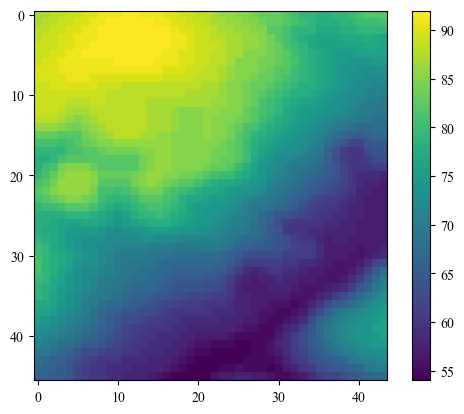

In [4]:
plt.imshow(farea_dem, interpolation='none')
plt.colorbar()
plt.show()

In [5]:
crs = CRS.from_epsg("26917")
proj = Transformer.from_crs(crs.geodetic_crs, crs)

x_loc = np.zeros([farea_ras.height, farea_ras.width])
y_loc = np.zeros([farea_ras.height, farea_ras.width])
for i in range(farea_ras.height):
  for j in range(farea_ras.width):
    lon = farea_ras.xy(i,j)[0]
    lat = farea_ras.xy(i,j)[1]
    utm_x, utm_y =proj.transform(lat,lon) # Latitude/Longitude to UTM
    x_loc[i,j] = utm_x
    y_loc[i,j] = utm_y

In [6]:
slope = rd.TerrainAttribute(farea_dem, attrib='slope_riserun')
accum = rd.FlowAccumulation(farea_dem, method='D8')
twi   = np.log(accum/slope)


A/var/folders/4f/fztycq7j0wj0t_2bhzck543c0000gp/T/ipykernel_23324/3896729822.py:3: RuntimeWarning: divide by zero encountered in divide
  twi   = np.log(accum/slope)
 Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000452166===================  ] (97% - 0.0s - 1 threads)

A O'Callaghan (1984)/Marks (1984) D8/D4 Flow Accumulation
C O'Callaghan, J.F., Mark, D.M., 1984. The Extraction of Drainage Networks from Digital Elevation Data. Computer vision, graphics, and image processing 28, 323--344.

c topology = D8
[================================================= ] (99% - 0.0s - 1 threads)
A Generic Flow Accumulation Algorithm
p Creating dependencies array...

d Source cells found = 830
p Calculating flow accumulation...
t Wall-time       = 0.00122633 s============= ] (99% - 0.0s - 1 threads)


## Load Well Time Series Data + Preprocess

In [7]:
from pylenm2.data import filters

# Load and process well time-series data
# url_1 = 'https://raw.githubusercontent.com/ALTEMIS-DOE/pylenm/master/notebooks/data/FASB_Data_thru_3Q2015_Reduced_Demo.csv'
# url_2 = 'https://github.com/ALTEMIS-DOE/pylenm/blob/master/notebooks/data/FASB%20Well%20Construction%20Info.xlsx?raw=true'

url_1 = './data/FASB_Data_thru_3Q2015_Reduced_Demo.csv'
url_2 = './data/FASB Well Construction Info.xlsx'

concentration_data = pd.read_csv(url_1)
construction_data = pd.read_excel(url_2)
pylenm2_dm = PylenmDataModule(concentration_data)
filters.simplify_data(data=pylenm2_dm, inplace=True)
pylenm2_dm.set_construction_data(construction_data)

/var/folders/4f/fztycq7j0wj0t_2bhzck543c0000gp/T/ipykernel_23324/603169083.py:10: DtypeWarning: Columns (15,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  concentration_data = pd.read_csv(url_1)


Successfully imported the data!



In [8]:
analyte = 'TRITIUM'

Data summary for water table

In [9]:
from pylenm2.data import fetchers
# tr_details = pylenm_df.get_analyte_details(analyte)
tr_details = fetchers.get_analyte_details(
    data_pylenm_dm=pylenm2_dm, 
    analyte_name=analyte,
)
tr_details

,Start Date,End Date,Date Range (days),Unique samples
Station Name,,,,
FSB 77,1990-01-01,2006-10-16,6132,65
FSB111C,1990-01-01,2006-10-17,6133,67
FSB105C,1990-01-01,2006-10-19,6135,67
FSB111D,1990-01-01,2006-10-26,6142,68
FSB107D,1990-01-01,2007-02-01,6240,68
...,...,...,...,...
FSB146D,2015-04-29,2015-09-09,133,9
FSB145D,2015-04-30,2015-09-09,132,9
FSB143D,2015-05-04,2015-09-09,128,9


Select wells that have enough and recent samples

In [10]:
n_samples = tr_details['Unique samples']
end_date = tr_details['End Date']
start_date = tr_details['Start Date']
well_names = tr_details.index
well_enough = well_names[n_samples>20]

well_recent = well_names[end_date > datetime.strptime('2015-01-01', '%Y-%m-%d').date()]
well_old = well_names[start_date < datetime.strptime('2006-01-01', '%Y-%m-%d').date()]

Temporal interpolation of the time series at equal frequency

In [11]:
from pylenm2.data import transformation

# tr_interp = pylenm_df.interpolate_wells_by_analyte(analyte, frequency='1M', rm_outliers=True, z_threshold=3)
tr_interp = transformation.interpolate_stations_by_analyte(
    data_pylenm_dm=pylenm2_dm,
    analyte=analyte, 
    frequency='1M', 
    rm_outliers=True, 
    z_threshold=3,
)

In [12]:
tr_interp[tr_interp <= 0] = 0.001

Select the upper aquifer wells and the wells that have enough samples

44 wells


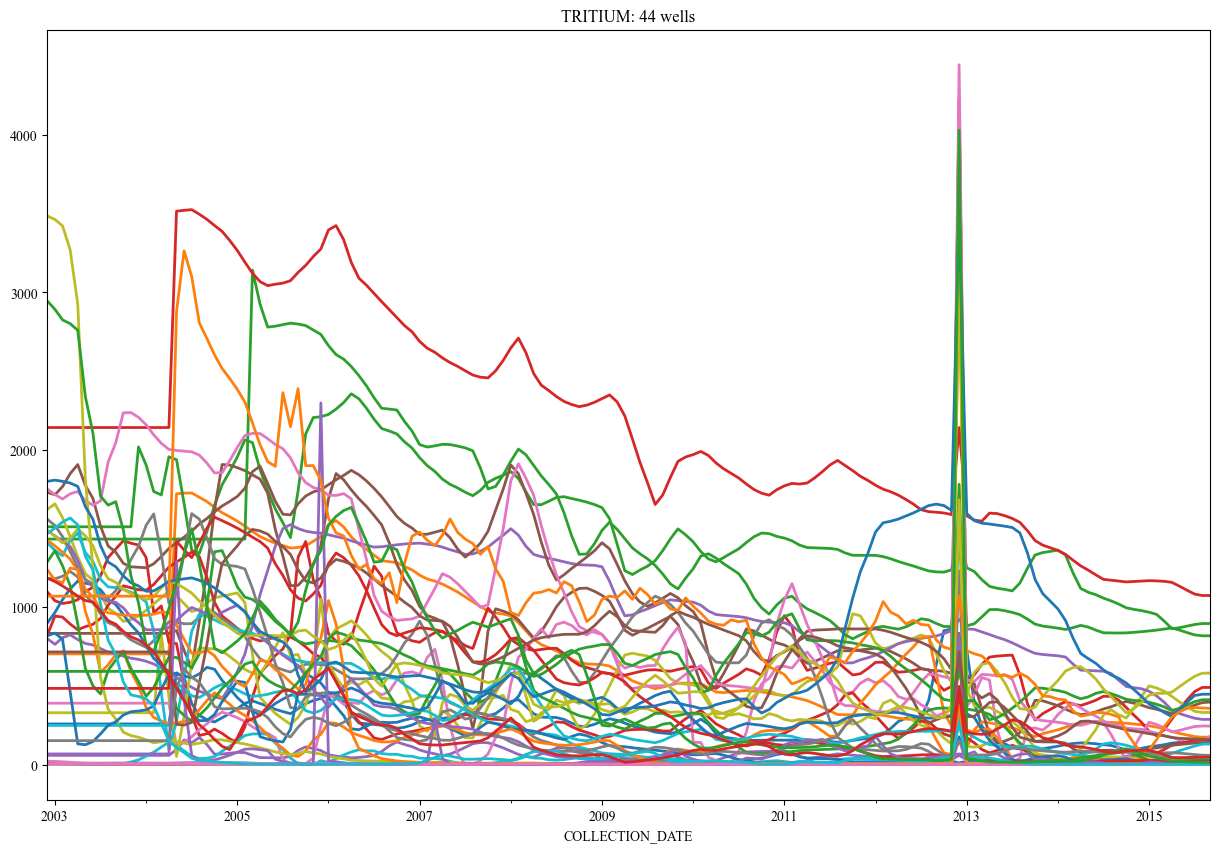

In [13]:
import numpy as np
from pylenm2.data import filters

active = list(np.unique(filters.filter_by_column(
    pylenm2_dm.get_construction_data(), 
    col='WELL_USE', 
    equals=['ACTIVE'],
).index))

upper_wells = list(np.unique(filters.filter_by_column(
    pylenm2_dm.get_construction_data(), 
    col='AQUIFER', 
    equals=['UAZ_UTRAU'],
).index))

well_only_D = list(
    set(upper_wells) & 
    set(tr_interp.columns) & 
    set(well_enough) & 
    set(well_recent) & 
    set(well_old) & 
    set(active)
)

tr_interp = tr_interp[well_only_D]

tr_interp.plot(figsize=(15,10), legend=False, linewidth=2, title=str(analyte + ": {} wells".format(tr_interp.shape[1])))

print(tr_interp.shape[1], "wells")

In [14]:
keep = list(tr_interp.describe().T[tr_interp.describe().T['min']>0].T.columns)
tr_interp = tr_interp[keep]

Let's remove the 'bad' time series wells

In [15]:
bad_ones = ['FSB 89D', 'FSB128D', 'FSB104D', 'FSB 91D', 'FSB 99D', 'FSB117D']
tr_interp = tr_interp.drop(columns=bad_ones)

In [16]:
# Reorder columns to be in alphabetical order
tr_interp = tr_interp.reindex(sorted(tr_interp.columns), axis=1)

38 wells


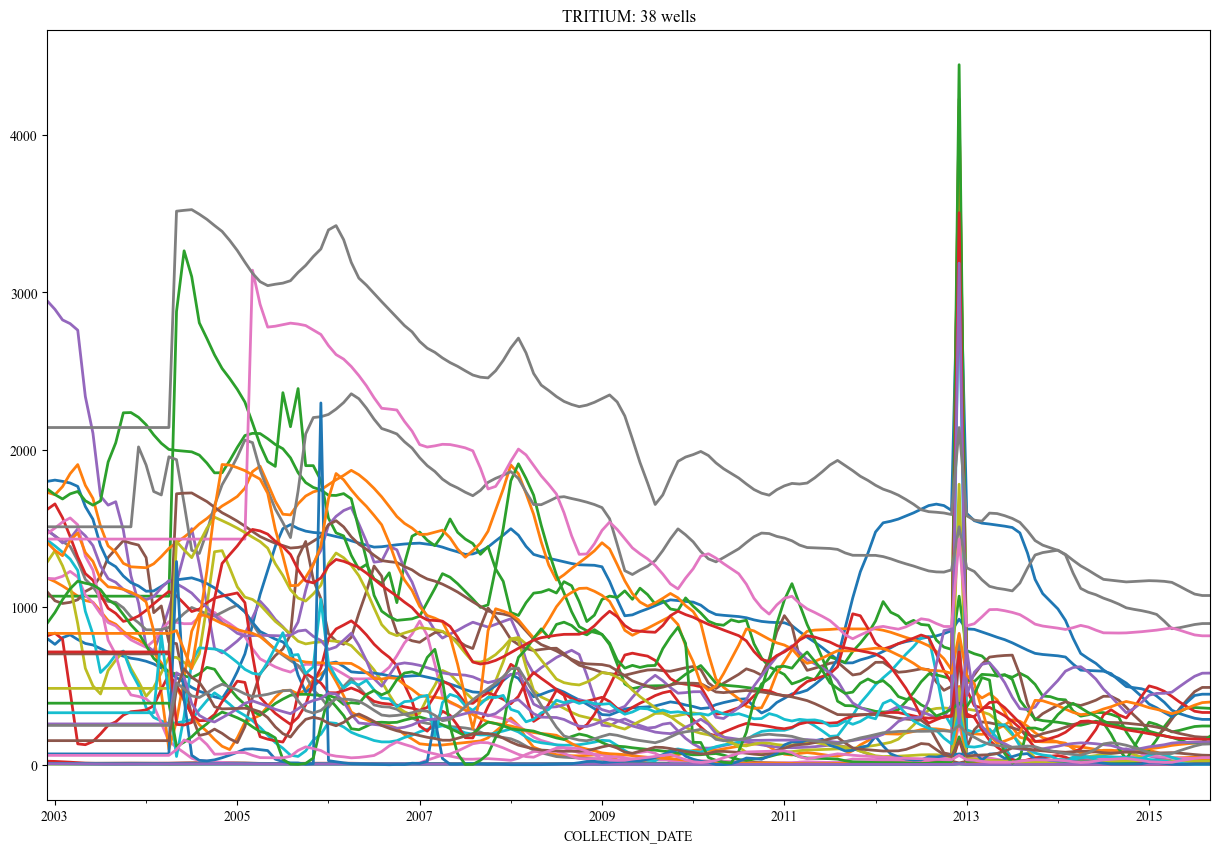

In [17]:
tr_interp.plot(figsize=(15,10), legend=False, linewidth=2, title=str(analyte + ": {} wells".format(tr_interp.shape[1])))
print(tr_interp.shape[1], "wells")

## Well Location Data

In [18]:
well_info = pylenm2_dm.get_construction_data()

Match the well indecies between the time series and locations

In [19]:
shared_wells = list(set(well_info.index) & set(tr_interp.columns))
tr_interp = tr_interp[shared_wells]
# Reorder columns to be in alphabetical order
tr_interp = tr_interp.reindex(sorted(tr_interp.columns), axis=1)

well_info = well_info.T[shared_wells]
# Reorder columns to be in alphabetical order
well_info = well_info.reindex(sorted(well_info.columns), axis=1)
well_info = well_info.T

In [20]:
crs = CRS.from_epsg("26917")
proj = Transformer.from_crs(crs.geodetic_crs, crs)
UTM_x, UTM_y = proj.transform(well_info.LATITUDE,well_info.LONGITUDE)

Take out the ground-surface elevation, and compute the water table elevation

In [21]:
well_info.LATITUDE.shape[0]

38

In [22]:
elev = well_info.REFERENCE_ELEVATION
elev.index = well_info.index
elev = elev.T
elev = elev * 0.3048 # convert to meters

In [23]:
tr_interp.describe().T['min'].min()

0.001

In [24]:
# tr_interp = np.log2(tr_interp)
tr_interp = np.log10(tr_interp)

<Axes: xlabel='COLLECTION_DATE'>

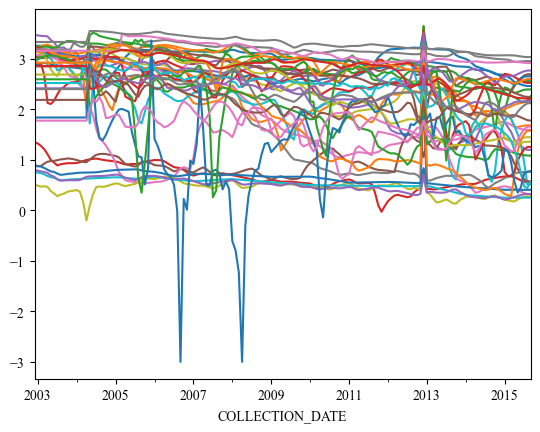

In [25]:
tr_interp.plot(legend=False)

In [26]:
# GETS APPROXIMATE tr VALUE IN THE XX GRID
def get_approx_predictions(
        X, 
        y_map, 
        XX,
    ):
    
    X_approx, y_approx = [],[]
    
    for i in range(X.shape[0]):
        x1, y1 = X.iloc[i].Easting, X.iloc[i].Northing # ACTUAL POINT
    
        abs_east = np.abs(XX.Easting-x1)
        abs_north= np.abs(XX.Northing-y1)
    
        c = np.maximum(abs_north,abs_east)
    
        index = np.argmin(c)
        XX.iloc[index].Easting, XX.iloc[index].Northing
    
        X_approx.append([
            XX.iloc[index].Easting, 
            XX.iloc[index].Northing, 
            XX.iloc[index].Elevation,
        ])
        y_approx.append(y_map[index])
    
    X_approx = pd.DataFrame(
        X_approx, columns=['Easting', 'Northing', 'Elevation'],
    )
    
    return X_approx, y_approx

In [27]:
X = np.vstack((UTM_x,UTM_y, elev.values)).T
X = pd.DataFrame(X, columns=['Easting', 'Northing', 'Elevation'])

XX = np.vstack([x_loc.flatten(), y_loc.flatten(), farea_dem.flatten(), slope.flatten(), accum.flatten()]).T
XX = pd.DataFrame(XX, columns=['Easting', 'Northing', 'Elevation', 'Slope', 'Acc'])

X_approx, Slope_X = get_approx_predictions(X, slope.flatten(), XX)
X_approx, Acc_X = get_approx_predictions(X, accum.flatten(), XX)

X = np.vstack((UTM_x,UTM_y, elev.values, Slope_X, Acc_X)).T
X = pd.DataFrame(X, columns=['Easting', 'Northing', 'Elevation', 'Slope', 'Acc'])

In [28]:
year = 2015
y = np.array(tr_interp.loc[tr_interp.index[pd.Series(tr_interp.index).dt.year == year]].mean())
print(y)
well_names = list(tr_interp.columns)

[2.5377152  1.73972904 2.42145596 0.61874604 1.39505552 2.51289214
 1.6475616  0.72357937 1.40841397 1.32400839 2.58197849 2.09403204
 2.37735159 2.60385993 2.70227327 0.85258422 0.3950617  2.95583734
 0.22681089 0.25043046 0.404937   0.97724643 1.12601957 0.96527693
 0.27689561 2.30712207 2.92608084 3.0514239  1.35560232 0.97612596
 0.77709346 2.5562661  2.22587754 2.23894009 2.12815083 1.84184242
 1.40756846 1.96777647]


In [29]:
def dist(p1,p2):
    return sqrt(((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2))

def add_dist_to_basin(XX, basin_coordinate=[436642.70,3681927.09], col_name='dist_to_basin'):
    x1,y1 = basin_coordinate
    distances = []
    for i in range(XX.shape[0]):
        x2,y2 = XX.iloc[i][0], XX.iloc[i][1]
        distances.append(dist([x1,y1],[x2,y2]))
    XX[col_name] = distances
    return XX

In [30]:
b_c=[436642.70,3681927.09]
XX = add_dist_to_basin(XX, basin_coordinate=b_c)
X = add_dist_to_basin(X, basin_coordinate=b_c)

In [31]:
from pylenm2.stats import gp as stats_gp

y_map, r_map, residuals, lr_trend = stats_gp.interpolate_topo(
    X, 
    y, 
    XX, 
    ft=['Elevation', 'dist_to_basin'], 
    regression='linear', 
    smooth=True,
)
y_map[y_map<0] = 0

/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/pylenm_env/lib/python3.

<Axes: >

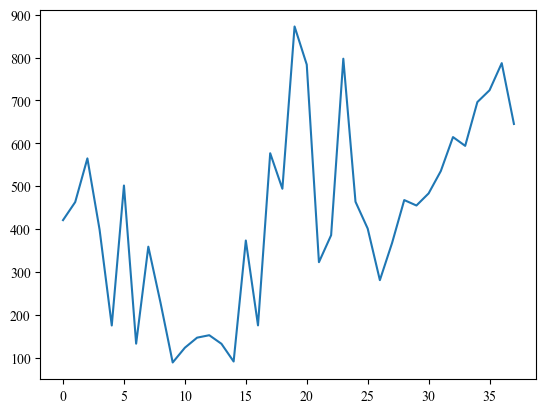

In [32]:
X.dist_to_basin.plot()

/var/folders/4f/fztycq7j0wj0t_2bhzck543c0000gp/T/ipykernel_23324/455199505.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


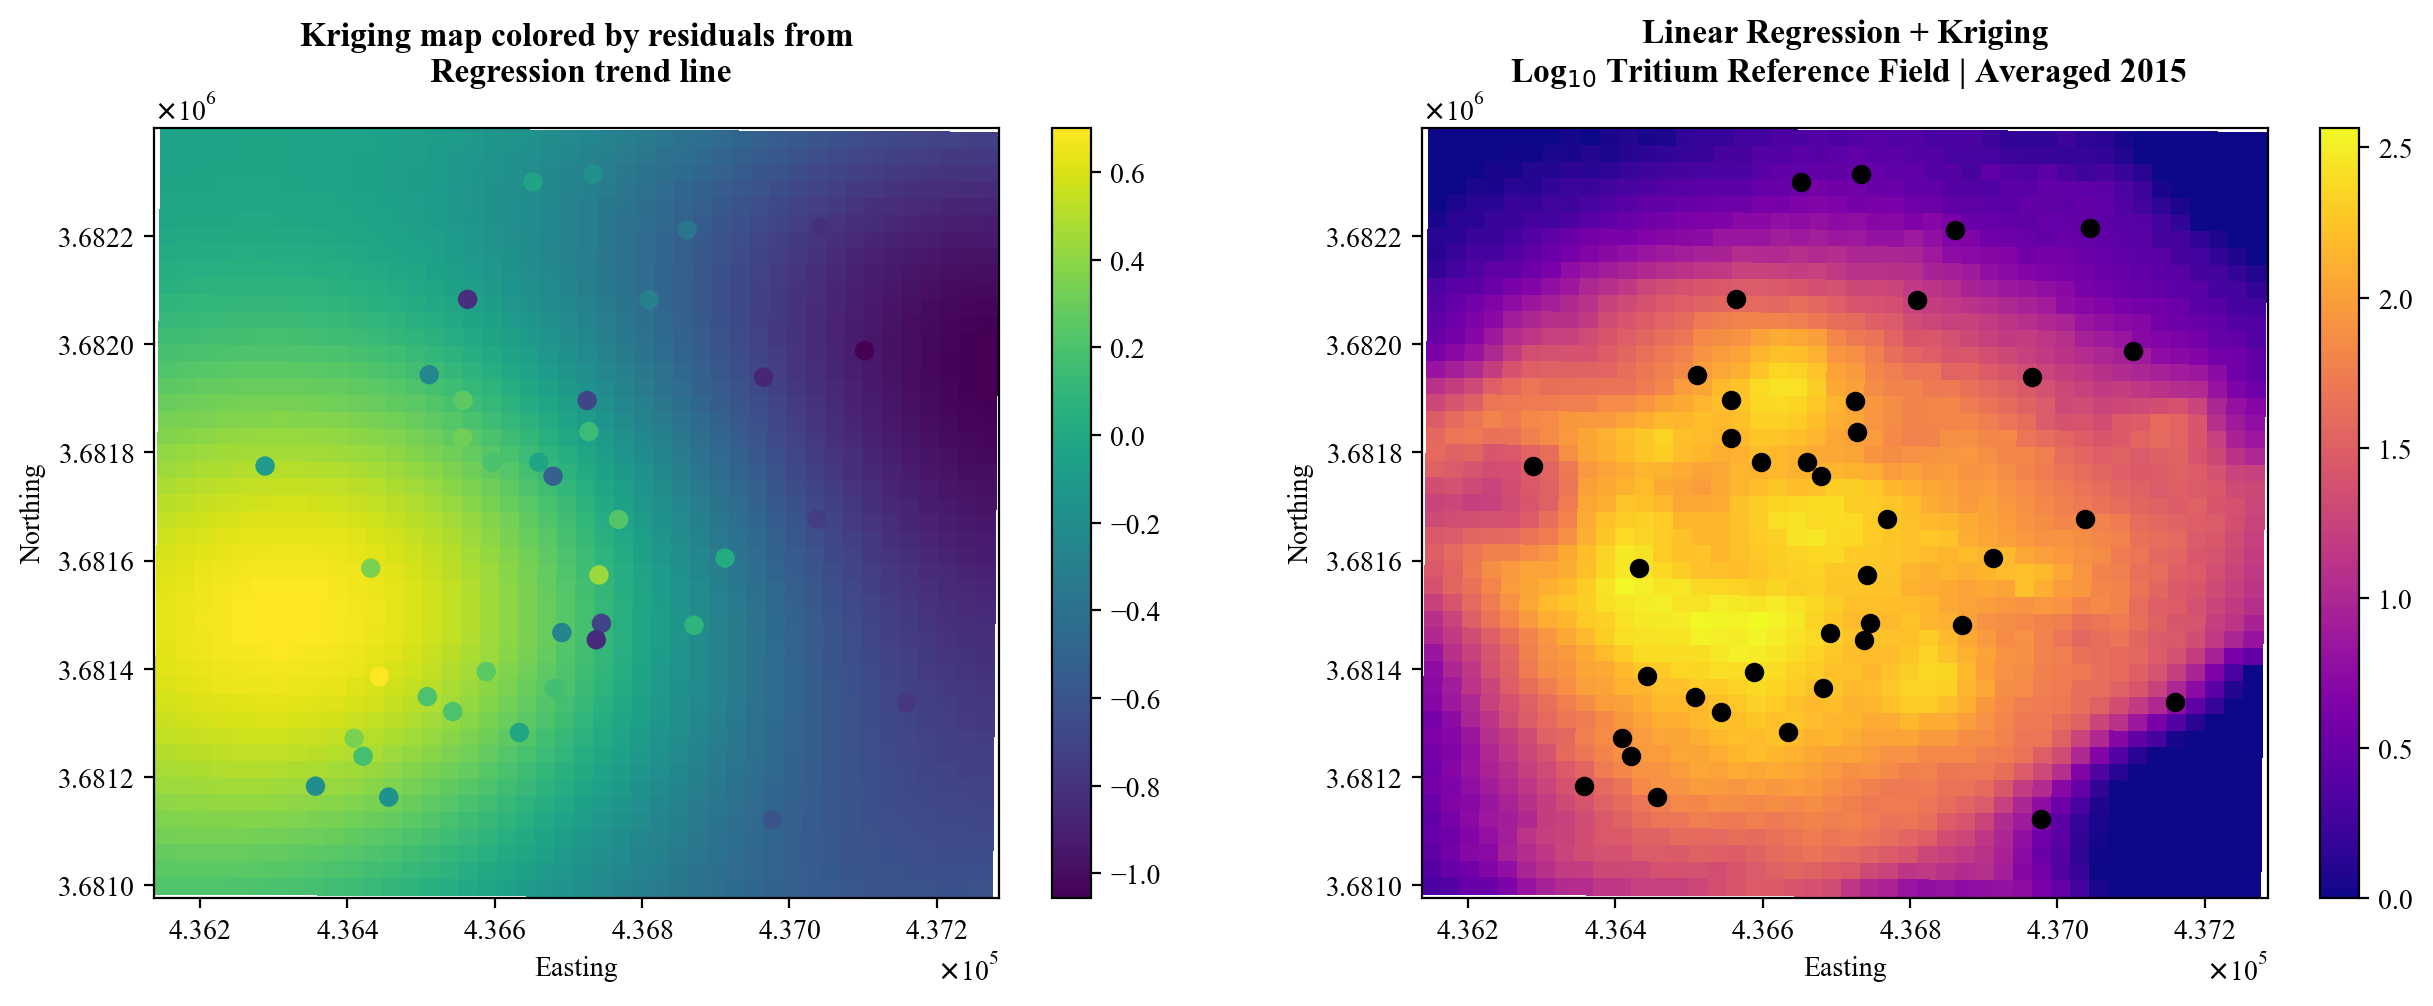

In [33]:
# Plot all result details
fig, ax = plt.subplots(1,2, figsize=(15,5), dpi=200)
xx = np.array(XX)

titles = ["Kriging map colored by residuals from\n Regression trend line", str("Linear Regression + Kriging\n Log{} Tritium Reference Field | {}{}".format('$_{10}$',"Averaged ",year,))]

map_0 = ax[0].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                r_map.reshape(x_loc.shape))
fig.colorbar(map_0, ax=ax[0])

map_1 = ax[1].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                y_map.reshape(x_loc.shape), 
                cmap='plasma')
fig.colorbar(map_1, ax=ax[1])

colors=[residuals, 'black']
# ax[0].scatter(X.iloc[:,0], X.iloc[:,1], c=colors, alpha=1)

for i in range(2):
    ax[i].scatter(X.iloc[:,0], X.iloc[:,1], c=colors[i], alpha=1)
    ax[i].set_xlabel("Easting")
    ax[i].set_ylabel("Northing")
    ax[i].set_title(titles[i],y=1.04,fontweight='bold')
    ax[i].ticklabel_format(style='sci', axis='both',scilimits=(-1,1), useMathText=True)

fig.show()

In [34]:
from pylenm2.stats import metrics

pd.set_option('max_colwidth', 100)

from sklearn.exceptions import ConvergenceWarning
import warnings
for msg in WARNING_MESSAGES_TO_IGNORE:
    warnings.filterwarnings(
        "ignore", 
        message=msg,
    )
    warnings.filterwarnings(
        "ignore",
        category=ConvergenceWarning,
    )

# TEST ALL - Regular Fitting Process
model_results = pd.DataFrame(columns=['model', 'features', 'mse', 'r2'])

# Save GP results 
gp, y_map_gp = stats_gp.fit_gp(X=X[['Easting', 'Northing']], y=y, xx=XX[['Easting', 'Northing']])
# y_map_gp = y_map_gp_here
X_approx, y_approx = get_approx_predictions(X, y_map_gp, XX)
model_results.loc[len(model_results.index)] = ["GP", np.NaN, metrics.mse(y, y_approx), r2_score(y, y_approx)]

feature_params = [['Elevation'], ['Elevation', 'dist_to_basin'],['Elevation', 'Slope'], ['Elevation', 'Slope', 'dist_to_basin'], ['Easting', 'Northing'], ['Easting', 'Northing', 'Elevation'], ['Easting', 'Northing', 'Elevation', 'dist_to_basin'],
['Easting', 'Northing', 'Elevation', 'Slope'], ['Easting', 'Northing', 'Elevation', 'Slope', 'dist_to_basin'], ['Easting', 'Northing', 'Elevation', 'Slope', 'Acc'], ['Easting', 'Northing', 'Elevation', 'Slope', 'Acc', 'dist_to_basin']]

# Save Results for our approach  
for ft in feature_params:
    y_map_lr, r_map_lr, residuals_lr, lr_trend = stats_gp.interpolate_topo(X, y, XX, ft=ft, regression='linear', smooth=True)
    y_map_rf, r_map_rf, residuals_rf, rf_trend = stats_gp.interpolate_topo(X, y, XX, ft=ft, regression='rf', smooth=True)
    y_map_rid, r_map_rid, residual_rid, rid_trend = stats_gp.interpolate_topo(X, y, XX, ft=ft, regression='ridge', smooth=True)
    y_map_las, r_map_las, residuals_las, las_trend = stats_gp.interpolate_topo(X, y, XX, ft=ft, regression='lasso', smooth=True)
    y_map_lr[y_map_lr<0] = 0
    y_map_rf[y_map_rf<0] = 0
    y_map_rid[y_map_rid<0] = 0
    y_map_las[y_map_las<0] = 0

    y_maps = [y_map_lr, y_map_rf, y_map_rid, y_map_las]
    model_names = ["Linear", "Random Forest", "Ridge", "Lasso"]
    for y_map, model_name in zip(y_maps, model_names):
        X_approx, y_approx = get_approx_predictions(X, y_map, XX)
        model_results.loc[len(model_results.index)] = [
            model_name, 
            ft, 
            metrics.mse(y, y_approx), 
            r2_score(y, y_approx),
        ]

In [35]:
model_results.sort_values(by='r2', ascending=False)

,model,features,mse,r2
32,Lasso,"[Easting, Northing, Elevation, Slope]",0.003047,0.995818
40,Lasso,"[Easting, Northing, Elevation, Slope, Acc]",0.003047,0.995818
31,Ridge,"[Easting, Northing, Elevation, Slope]",0.004791,0.993424
12,Lasso,"[Elevation, Slope]",0.005031,0.993094
29,Linear,"[Easting, Northing, Elevation, Slope]",0.005643,0.992254
39,Ridge,"[Easting, Northing, Elevation, Slope, Acc]",0.005707,0.992165
37,Linear,"[Easting, Northing, Elevation, Slope, Acc]",0.007505,0.989697
44,Lasso,"[Easting, Northing, Elevation, Slope, Acc, dist_to_basin]",0.019312,0.973489
9,Linear,"[Elevation, Slope]",0.027148,0.962733
11,Ridge,"[Elevation, Slope]",0.027270,0.962565


In [38]:
from tqdm import tqdm

# TEST ALL - Leave-One-Out Cross Validation Process
model_results_LOO = pd.DataFrame(columns=['model', 'features', 'mse', 'r2'])

# Save GP results
y_approx_loo_gp = []
loo = LeaveOneOut()

for train_index, test_index in tqdm(loo.split(X), desc="Leave One Out Splits"):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    gp, y_map_gp = stats_gp.fit_gp(X=X_train[['Easting', 'Northing']], y=y_train, xx=XX[['Easting', 'Northing']])
    X_approx_test_gp, y_approx_test_gp = get_approx_predictions(X_test, y_map_gp, XX)
    y_approx_loo_gp.append(y_approx_test_gp)
model_results_LOO.loc[len(model_results_LOO.index)] = [
    "GP", 
    np.NaN, 
    metrics.mse(y, y_approx_loo_gp), 
    r2_score(y, y_approx_loo_gp),
]

feature_params = [
    ['Elevation'], ['Elevation', 'dist_to_basin'],['Elevation', 'Slope'], 
    ['Elevation', 'Slope', 'dist_to_basin'], ['Easting', 'Northing'], 
    ['Easting', 'Northing', 'Elevation'], 
    ['Easting', 'Northing', 'Elevation', 'dist_to_basin'], 
    ['Easting', 'Northing', 'Elevation', 'Slope'], 
    ['Easting', 'Northing', 'Elevation', 'Slope', 'dist_to_basin'], 
    ['Easting', 'Northing', 'Elevation', 'Slope', 'Acc'], 
    ['Easting', 'Northing', 'Elevation', 'Slope', 'Acc', 'dist_to_basin'],
]

# Save Results for our approach  
for ft in tqdm(feature_params, desc="Feature Params"):
    
    y_approx_loo_lr, y_approx_loo_rf, y_approx_loo_rid, y_approx_loo_las = [], [], [], []
    loo = LeaveOneOut()
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        y_map_lr, r_map_lr, residuals_lr, lr_trend = stats_gp.interpolate_topo(X_train, y_train, XX, ft=ft, regression='linear', smooth=True)
        y_map_rf, r_map_rf, residuals_rf, rf_trend = stats_gp.interpolate_topo(X_train, y_train, XX, ft=ft, regression='rf', smooth=True)
        y_map_rid, r_map_rid, residual_rid, rid_trend = stats_gp.interpolate_topo(X_train, y_train, XX, ft=ft, regression='ridge', smooth=True)
        y_map_las, r_map_las, residuals_las, las_trend = stats_gp.interpolate_topo(X_train, y_train, XX, ft=ft, regression='lasso', smooth=True)
        
        y_map_lr[y_map_lr<0] = 0
        y_map_rf[y_map_rf<0] = 0
        y_map_rid[y_map_rid<0] = 0
        y_map_las[y_map_las<0] = 0

        X_approx_test_lr, y_approx_test_lr = get_approx_predictions(X_test, y_map_lr, XX)
        X_approx_test_rf, y_approx_test_rf = get_approx_predictions(X_test, y_map_rf, XX)
        X_approx_test_rid, y_approx_test_rid = get_approx_predictions(X_test, y_map_rid, XX)
        X_approx_test_las, y_approx_test_las = get_approx_predictions(X_test, y_map_las, XX)
        
        y_approx_loo_lr.append(y_approx_test_lr)
        y_approx_loo_rf.append(y_approx_test_rf)
        y_approx_loo_rid.append(y_approx_test_rid)
        y_approx_loo_las.append(y_approx_test_las)

    y_preds = [
        y_approx_loo_lr, 
        y_approx_loo_rf, 
        y_approx_loo_rid, 
        y_approx_loo_las,
    ]
    model_names = [
        "Linear", 
        "Random Forest", 
        "Ridge", 
        "Lasso",
    ]
    
    for y_approx, model_name in zip(y_preds, model_names):
        model_results_LOO.loc[len(model_results_LOO.index)] = [model_name, ft, metrics.mse(y, y_approx), r2_score(y, y_approx)]

Leave One Out Splits: 38it [00:48,  1.26s/it]
Feature Params: 100%|██████████| 11/11 [14:58<00:00, 81.71s/it]


In [39]:
model_results_LOO.sort_values(by='r2', ascending=False)

,model,features,mse,r2
25,Linear,"[Easting, Northing, Elevation, dist_to_basin]",0.402798,0.447065
27,Ridge,"[Easting, Northing, Elevation, dist_to_basin]",0.403348,0.446311
15,Ridge,"[Elevation, Slope, dist_to_basin]",0.421425,0.421496
13,Linear,"[Elevation, Slope, dist_to_basin]",0.423793,0.418245
16,Lasso,"[Elevation, Slope, dist_to_basin]",0.423793,0.418245
28,Lasso,"[Easting, Northing, Elevation, dist_to_basin]",0.433268,0.405238
33,Linear,"[Easting, Northing, Elevation, Slope, dist_to_basin]",0.441084,0.394508
35,Ridge,"[Easting, Northing, Elevation, Slope, dist_to_basin]",0.447468,0.385746
34,Random Forest,"[Easting, Northing, Elevation, Slope, dist_to_basin]",0.456475,0.373381
42,Random Forest,"[Easting, Northing, Elevation, Slope, Acc, dist_to_basin]",0.463192,0.364160


In [40]:
from sklearn.exceptions import ConvergenceWarning
import warnings
for msg in WARNING_MESSAGES_TO_IGNORE:
    warnings.filterwarnings(
        "ignore", 
        message=msg,
    )
    warnings.filterwarnings(
        "ignore",
        category=ConvergenceWarning,
    )


y_map, r_map, residuals, trend = stats_gp.interpolate_topo(
    X, 
    y, 
    XX, 
    ft=['Easting', 'Northing', 'Elevation','Slope', 'Acc'], 
    regression='lasso', 
    smooth=True, 
)
y_map[y_map<0] = 0

/var/folders/4f/fztycq7j0wj0t_2bhzck543c0000gp/T/ipykernel_23324/1379322001.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[i].scatter(X.iloc[:,0], X.iloc[:,1], c=colors[i], alpha=1, cmap='plasma')
/var/folders/4f/fztycq7j0wj0t_2bhzck543c0000gp/T/ipykernel_23324/1379322001.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


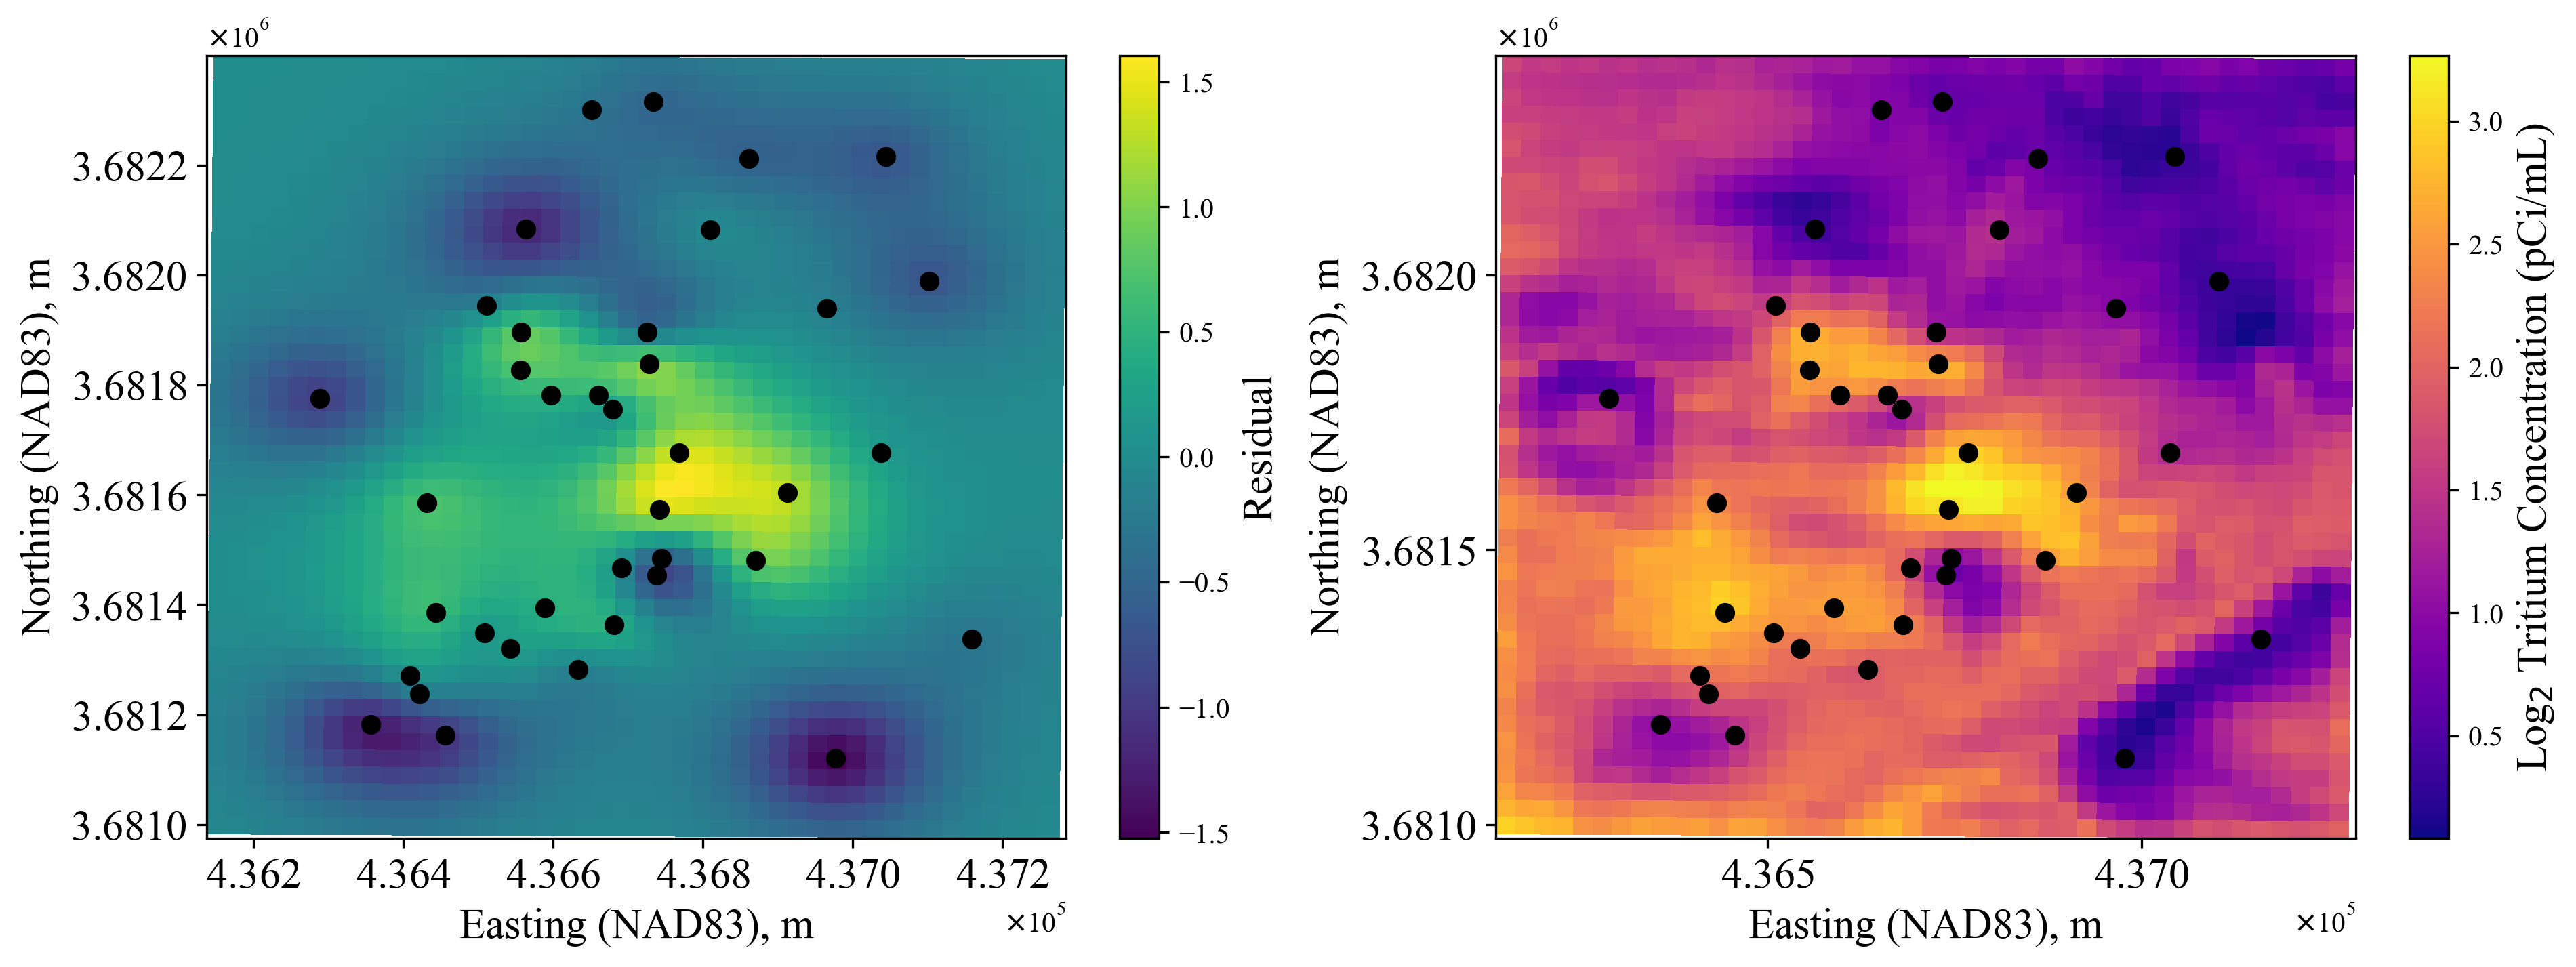

In [41]:
# Plot all result details
fig, ax = plt.subplots(1,2, figsize=(15,5), dpi=300)
fontsize=15

xx = np.array(XX)
plt.locator_params(axis='both', nbins=4, tight=False)

titles = ["Kriging map colored by residuals from\n Regression trend line", str("Linear Regression + Kriging\n Log{} Tritium Reference Field | {}".format('$_{2}$',"Averaged 2011",))]

map_0 = ax[0].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                r_map.reshape(x_loc.shape))
fig.colorbar(map_0, ax=ax[0]).set_label(label='Residual',size=fontsize)

map_1 = ax[1].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                y_map.reshape(x_loc.shape), 
                cmap='plasma')
fig.colorbar(map_1, ax=ax[1]).set_label(label="Log{} Tritium Concentration ({})".format('$_{2}$', pylenm2_dm.get_unit('TRITIUM')), size=fontsize)

colors=['black', 'black']

for i in range(2):
    ax[i].scatter(X.iloc[:,0], X.iloc[:,1], c=colors[i], alpha=1, cmap='plasma')
    plt.rc('font', size=fontsize)
    ax[i].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[i].set_xlabel("Easting (NAD83), m", fontsize=fontsize)
    ax[i].set_ylabel("Northing (NAD83), m", fontsize=fontsize)
    ax[i].ticklabel_format(style='sci', axis='both',scilimits=(-1,1), useMathText=True)

plt.locator_params(axis='x', nbins=4, tight=False)
plt.locator_params(axis='y', nbins=4, tight=False)

fig.show()

In [42]:
X_approx, y_approx = get_approx_predictions(X, y_map, XX)

/var/folders/4f/fztycq7j0wj0t_2bhzck543c0000gp/T/ipykernel_23324/1362296515.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


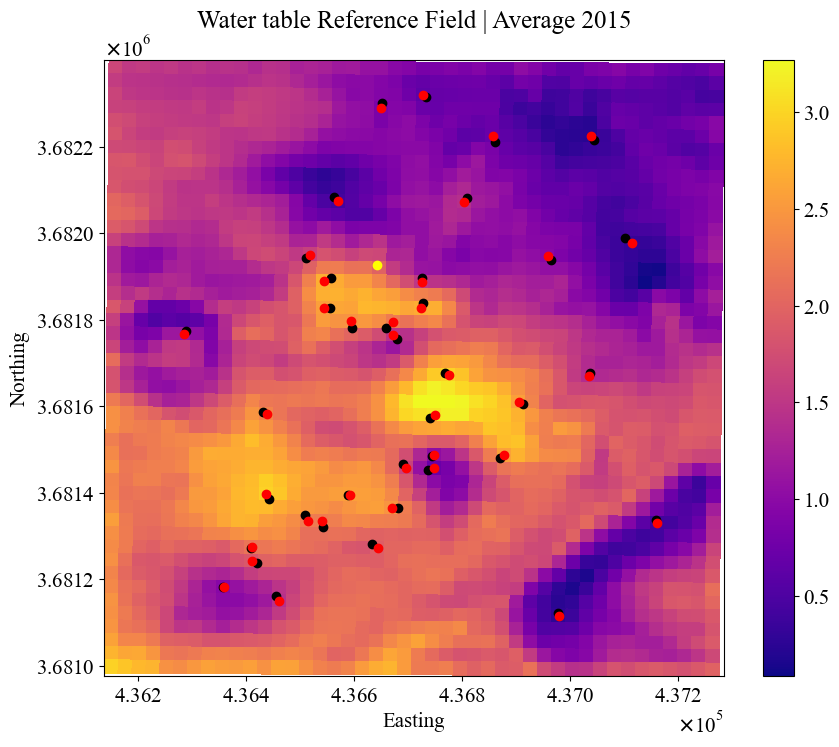

In [43]:
# Plot all result details
fig, ax = plt.subplots(1,1,figsize=(10,8))

xx = np.array(XX)

titles = [str("Water table Reference Field | Average {}".format(year))]

map_1 = ax.pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                y_map.reshape(x_loc.shape), 
                cmap='plasma')
fig.colorbar(map_1, ax=ax)

ax.scatter(X.iloc[:,0], X.iloc[:,1], c='black', alpha=1) # Real point
ax.scatter(X_approx.iloc[:,0], X_approx.iloc[:,1], c='red', alpha=1) # Approximate point
ax.scatter(b_c[0], b_c[1], c='yellow', alpha=1) # Approximate point

ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
ax.set_title(titles[0],y=1.04)
ax.ticklabel_format(style='sci', axis='both',scilimits=(-1,1), useMathText=True)


fig.show()

MSE LR:  0.0030467555036679454
R^2 LR:  0.9958176154196874
[0.    0.006 0.012 0.019 0.025 0.031]


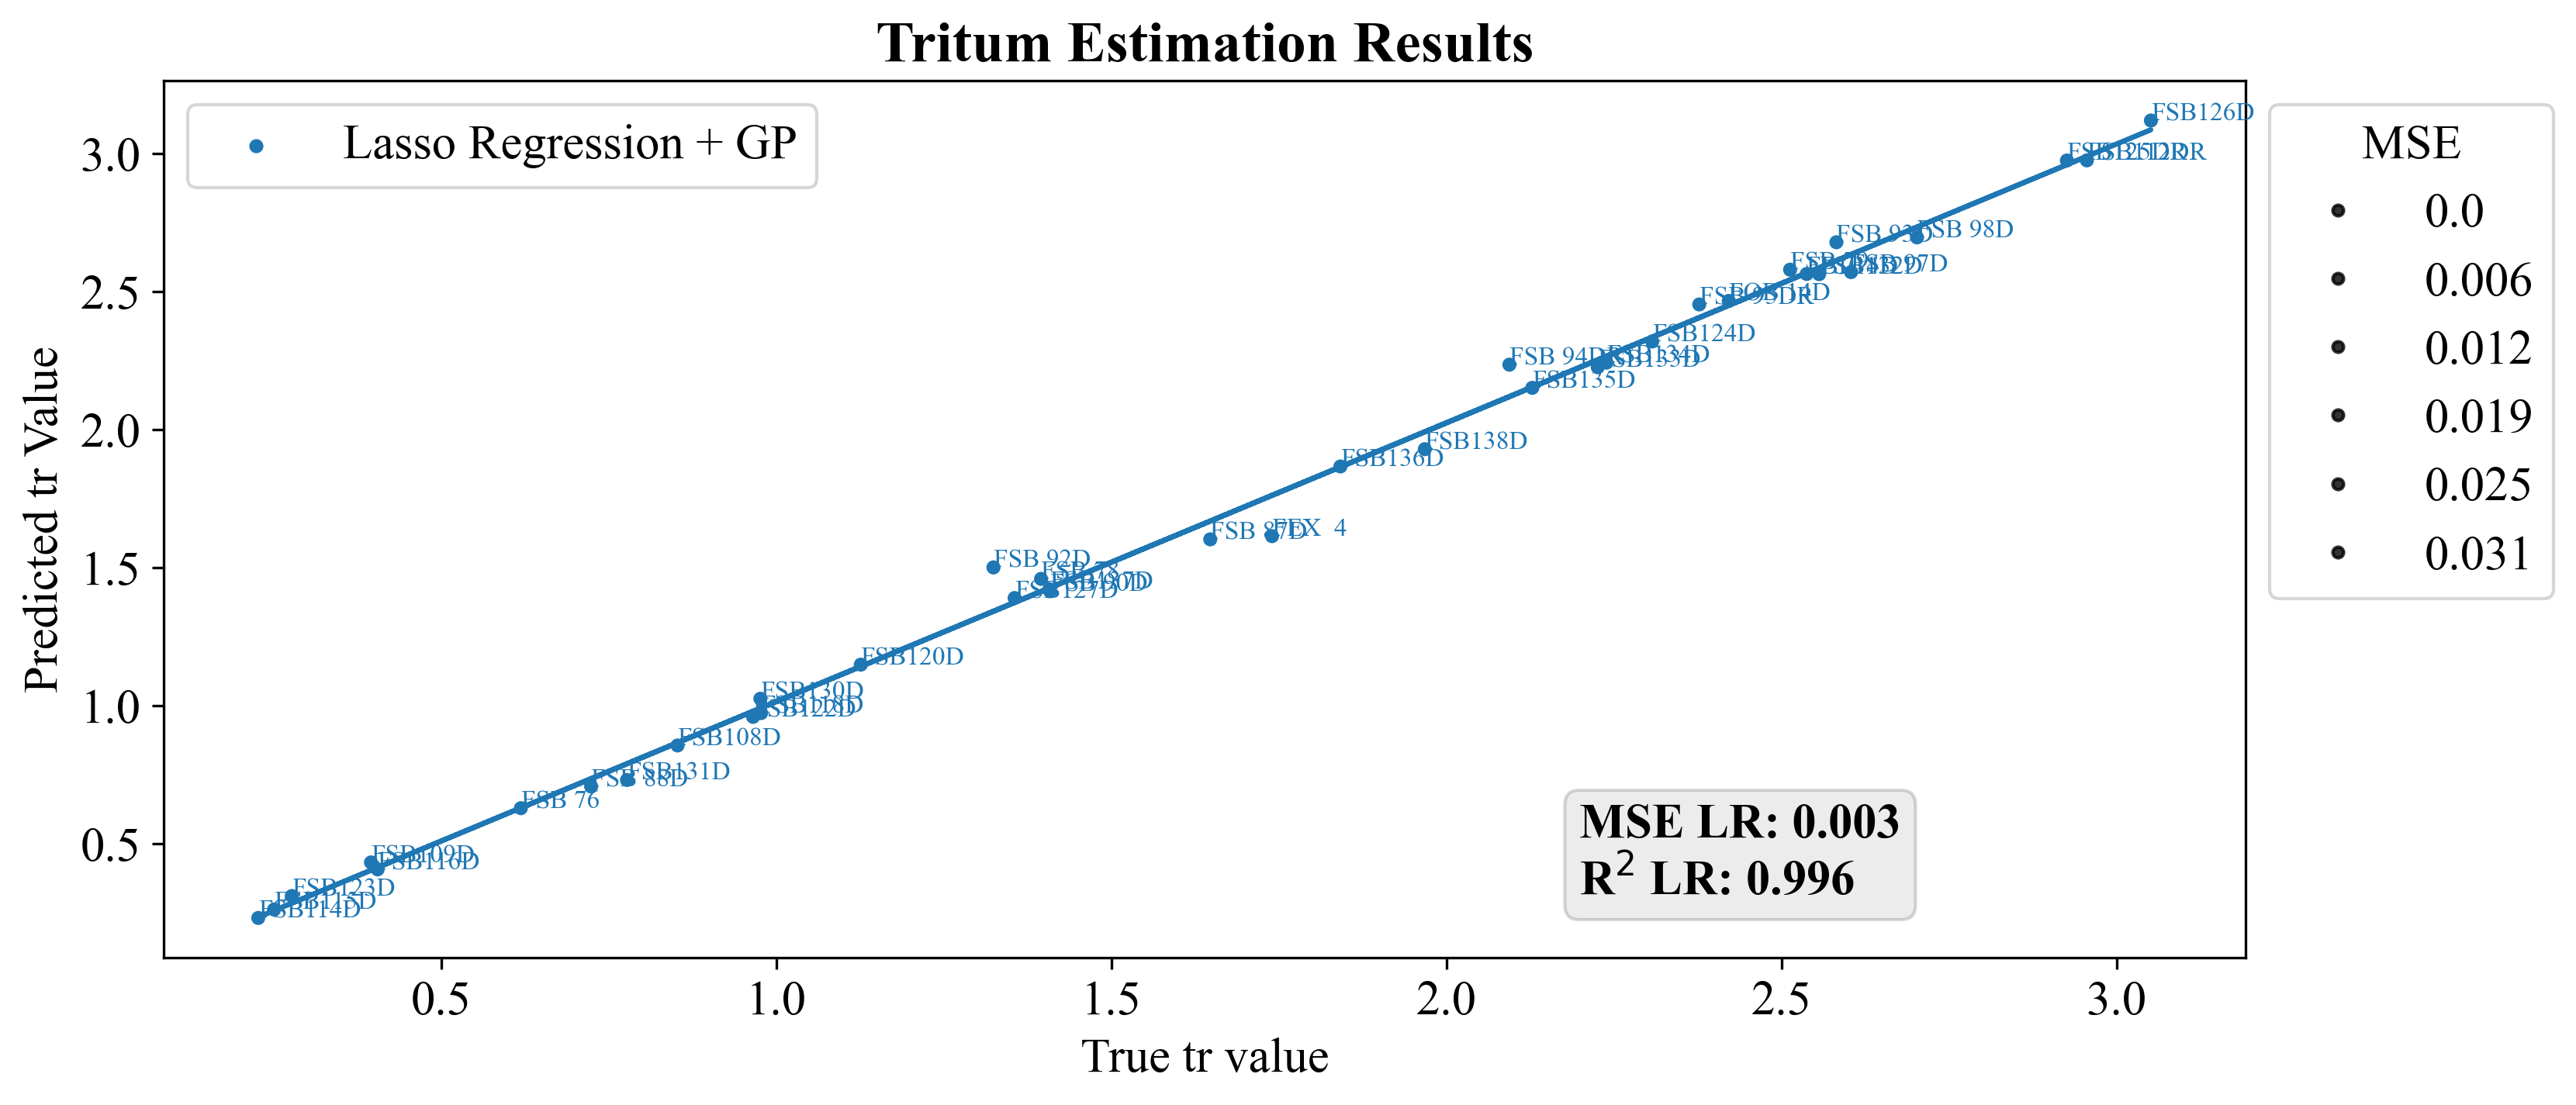

<Figure size 1280x960 with 0 Axes>

In [44]:
from pylenm2.stats import metrics

fig, ax = plt.subplots(figsize=(10,5),dpi=300)
plt.rcParams["legend.loc"] = 'upper left'
print("MSE LR: ", metrics.mse(y, y_approx))

print("R^2 LR: ",r2_score(y, y_approx))
text = "MSE LR: {:.3f}".format(metrics.mse(y, y_approx)) + "\n" + "R{} LR: {:.3f}".format('$^{2}$', r2_score(y, y_approx))
plt.figure( dpi=200)
ax.set_title('Tritum Estimation Results',fontweight='bold')
ax.set_xlabel('True tr value')
ax.set_ylabel('Predicted tr Value')

err_lr = []
for i in range(len(y)):
    err_lr.append(metrics.mse([y[i]], [y_approx[i]]))
minmaxscaler=MinMaxScaler()
minmaxscaler.fit_transform(np.array(err_lr).reshape(-1,1)).flatten().tolist()

err_lr_s = [(x+5)**1.5 for x in err_lr]
scatter1 = ax.scatter(y, y_approx, label = "Lasso Regression + GP", s=err_lr_s)
props = dict(boxstyle='round', facecolor='grey', alpha=0.15)
fig.tight_layout()
fig.text(0.68, 0.06, text, transform=ax.transAxes, fontsize=15, fontweight='bold', verticalalignment='bottom', bbox=props) #1.025, 0.06

m_lr, b_lr = np.polyfit(y.astype("float64"), np.array(y_approx).flatten(), 1)

legend1 = ax.legend()
ax.add_artist(legend1)
# produce a legend with a cross section of sizes from the scatter
handles, labels = scatter1.legend_elements(prop="sizes", alpha=0.8)
labels=np.round(np.linspace(min(np.array(err_lr).min(),np.array(err_lr).min()), max(np.array(err_lr).max(),np.array(err_lr).max()) ,6),3)
print(labels)
legend2 = ax.legend(handles, labels, title="MSE", bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
for i, txt in enumerate(well_names):
    ax.annotate(txt, (y[i], y_approx[i]), fontsize=8, color='#1f77b4')

ax.plot(y, m_lr*y + b_lr)